# 这个脚本用来测试，是否当前多边形为凸边形，如果是凹边形，则拆分成凸边形

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon
from shapely import affinity
from CPP_Planner import CPP_Planner_Kit

<Axes: >

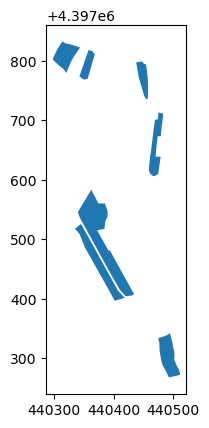

In [2]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
all_land.plot()

<Axes: >

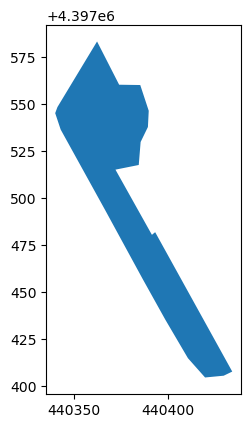

In [3]:
# 获取一个凹边形
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
single_land.plot()

In [4]:
single_polygon = single_land.geometry.iloc[0]
type(single_polygon)

shapely.geometry.polygon.Polygon

length:  13.728793154983508
length:  23.684009339982456
length:  24.725610545458427
length:  41.44857898438452
length:  49.35949576573215
length:  9.186873271994488
length:  3.4207024148067213
length:  40.780118634712146
length:  25.82648026866554
length:  11.23272315212225
length:  14.422685823429143
length:  8.6275310012739
length:  8.877523895759099
length:  12.268700349940415
length:  12.641731616151134
length:  39.73763547401711
length:  2.2327805641076166
length:  84.73170610760316
length:  5.058942420889911
length:  9.941951003067594
length:  0.0
Counted edge:  21


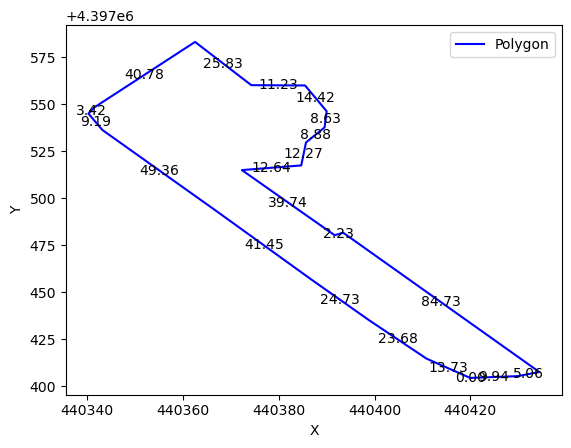

In [5]:
def plot_polygon_with_edge_length(polygon):
    # 提取多边形的坐标
    x, y = polygon.exterior.xy

    # 计算每条边的长度
    # edge_lengths = [calc_distance(polygon.exterior.coords[i], polygon.exterior.coords[i + 1]) for i in range(len(polygon.exterior.coords) - 1)]
    # 重新做一个存储坐标的表，末尾再存储一次第一个点
    coords_x = [temp_x for temp_x in x]
    coords_x.append(x[0])
    coords_y = [temp_y for temp_y in y]
    coords_y.append(y[0])
    # edge_lengths = [calc_distance([coords_x[i], coords_y[i]], [coords_x[i+1], coords_y[i+1]]) for i in range(len(coords_x)-1)]
    edge_lengths = []
    for i in range(len(coords_x) - 1):
        length = ((coords_x[i] - coords_x[i+1])**2 + (coords_y[i] - coords_y[i+1])**2) ** 0.5
        print("length: ", length)
        edge_lengths.append(length)
    print("Counted edge: ", len(edge_lengths))

    # 绘制多边形
    plt.plot(x, y, 'b-', label='Polygon')

    # 在每条边旁边显示长度
    for i, length in enumerate(edge_lengths):
        # edge_midpoint = polygon.exterior.interpolate(i + 0.5, normalized=True)
        # 将边显示到每条边的中点上
        edge_midpoint = [(coords_x[i] + coords_x[i+1])/2, (coords_y[i] + coords_y[i+1])/2]
        plt.text(edge_midpoint[0], edge_midpoint[1], f'{length:.2f}', ha='center', va='center')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

plot_polygon_with_edge_length(single_polygon)

# 尝试使用凸分割函数进行非凸边形的分割

In [6]:
from shapely.ops import linemerge, unary_union

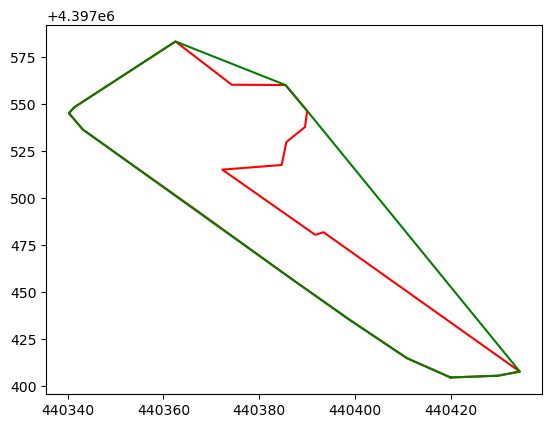

In [7]:
# 绘制当前的多边形，以及其convex_hull
fig, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, color='red')
ax.plot(*single_polygon.convex_hull.exterior.xy, color='green')

In [8]:
# 获取凸包上的所有的线，存储成单独的一根根线
convex_hull_lines = []
for i in range(len(single_polygon.convex_hull.exterior.coords)-1):
    convex_hull_lines.append(LineString([single_polygon.convex_hull.exterior.coords[i], single_polygon.convex_hull.exterior.coords[i+1]]))
# 获取原多边形的所有线，存储成单独的一根根线
polygon_lines = []
for i in range(len(single_polygon.exterior.coords)-1):
    polygon_lines.append(LineString([single_polygon.exterior.coords[i], single_polygon.exterior.coords[i+1]]))
[len(convex_hull_lines), len(polygon_lines)]

[12, 20]

In [9]:
# 得到所有的不再凸包上的线
not_on_convex_hull_lines = []
for polygon_line in polygon_lines:
    if polygon_line not in convex_hull_lines:
        not_on_convex_hull_lines.append(polygon_line)
[len(not_on_convex_hull_lines)]

[11]

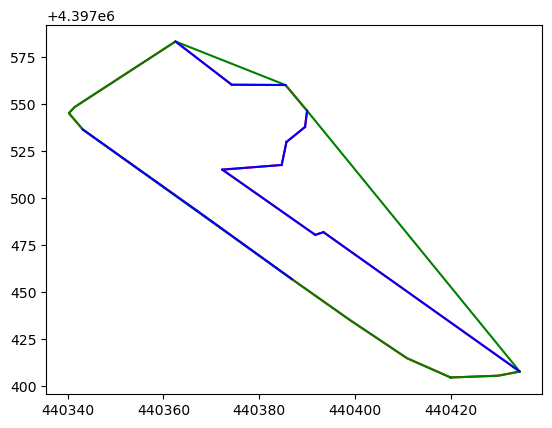

In [10]:
fig, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, color='red')
ax.plot(*single_polygon.convex_hull.exterior.xy, color='green')
for no_convex_line in not_on_convex_hull_lines:
    ax.plot(*no_convex_line.xy, color='blue')

In [11]:
from shapely.ops import split
# 使用所有在 not_on_convex_hull_lines 中的线，对 single_polygon 进行分割
# 从 not_on_convex_hull_lines 取出一条线，以其作为分割线，将 single_polygon 分割为两个多边形，同时判断是否有多边形为凸边形，如果一个都没有，则换一条线，如果有一个为凸边形，则放入分割完成的 convex_split_polygon 中，如果两个都是凸边形，则都放入 convex_split_polygon 中，结束循环
convex_split_polygon = []
for no_convex_line in not_on_convex_hull_lines:
    print(type(no_convex_line))
    # 将 single_polygon 分割为两个多边形
    # split_polygons = list(single_polygon.difference(no_convex_line))
    split_polygons = split(single_polygon, no_convex_line)
    print(type(split_polygons))
    # 判断两个多边形是否为凸边形
    convex_polygons = []
    for split_polygon in split_polygons:
        if split_polygon.is_convex:
            convex_polygons.append(split_polygon)
    # 如果两个都是凸边形，则都放入 convex_split_polygon 中
    if len(convex_polygons) == 2:
        convex_split_polygon.append(convex_polygons[0])
        convex_split_polygon.append(convex_polygons[1])
        break
    # 如果一个都没有，则换一条线
    elif len(convex_polygons) == 0:
        continue
    # 如果有一个为凸边形，则放入分割完成的 convex_split_polygon 中
    elif len(convex_polygons) == 1:
        convex_split_polygon.append(convex_polygons[0])
        break
[len(convex_split_polygon)]


<class 'shapely.geometry.linestring.LineString'>
<class 'shapely.geometry.collection.GeometryCollection'>


TypeError: 'GeometryCollection' object is not iterable

<class 'shapely.geometry.linestring.LineString'>
<class 'float'>


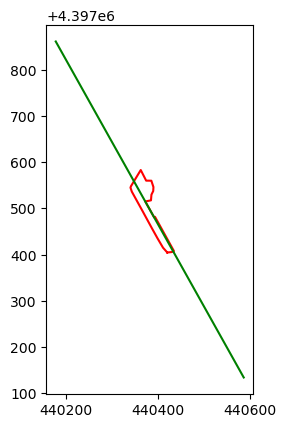

In [24]:
split_line = not_on_convex_hull_lines[8]
print(type(split_line))
print(type(split_line.xy[0][0]))
# 将 split_line 两端延长，得到一个很长的线
# x1 = split_line.xy[0][0]
# y1 = split_line.xy[1][0]
# x2 = split_line.xy[0][1]
# y2 = split_line.xy[1][1]

# 延长 split_line 为原来的2倍，保持原来的角度不变
# 获取线段的起始点和结束点的坐标
# x1, y1 = split_line.coords[0]
# x2, y2 = split_line.coords[1]
#
# # 计算线段的方向向量
# dx = x2 - x1
# dy = y2 - y1
# extended_dx = dx * 10
# extended_dy = dy * 10
#
# # 计算延长后的线段的结束点坐标
# extended_x2 = x2 + extended_dx
# extended_y2 = y2 + extended_dy
# extended_x1 = x1 - extended_dx
# extended_y1 = y1 - extended_dy
#
# # 另一个方向的延长
#
#
# extended_line = LineString([(extended_x1, extended_y1), (extended_x2, extended_y2)])
extended_line = CPP_Planner_Kit.extend_shapely_line(split_line)


# 切割多边形
# splitted_polygon = single_polygon.difference(extend_line)

fig, ax = plt.subplots()
# ax.plot(*single_polygon.exterior.xy, color='red')
# ax.plot(*splitted_polygon.exterior.xy, color='red')
ax.plot(*single_polygon.exterior.xy, color='red')
x, y = extended_line.xy
ax.plot(x, y, color='green')
ax.set_aspect('equal')

In [15]:
# print(split_line)
# split_line = split_line.buffer(2, cap_style=3)
# print("------------------------------")
# print(split_line)
# # split_line = LineString([(split_line.xy[0][0]-100, split_line.xy[1][0]-100), (split_line.xy[0][1]+100, split_line.xy[1][1]+100)])
# split_line

In [16]:
# 将 single_polygon 分割为两个多边形，分割线为 split_line 所在的延长线
split_polygon = split(single_polygon, split_line)

In [17]:
for geom in split_polygon.geoms:
    print(type(geom))

<class 'shapely.geometry.polygon.Polygon'>


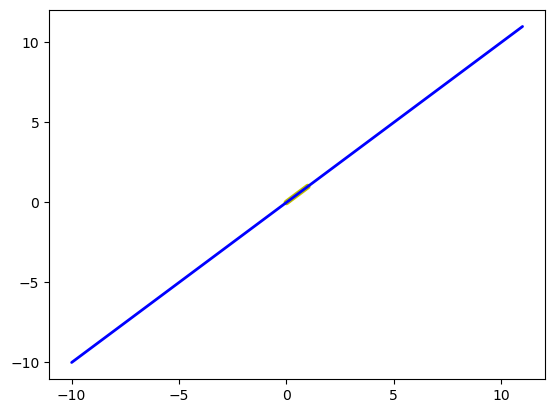

In [18]:
line1 = LineString([[0, 0], [1, 1]])
x1 = line1.xy[0][0]
y1 = line1.xy[1][0]
x2 = line1.xy[0][1]
y2 = line1.xy[1][1]
line2 = LineString([[x1 -10, y1-10], [x2+10, y2+10]])
# draw
fig, ax = plt.subplots()
x, y = line1.xy
ax.plot(x, y, color='y', linewidth=4, solid_capstyle='round', zorder=1)
x, y = line2.xy
ax.plot(x, y, color='blue', linewidth=2, solid_capstyle='round', zorder=2)

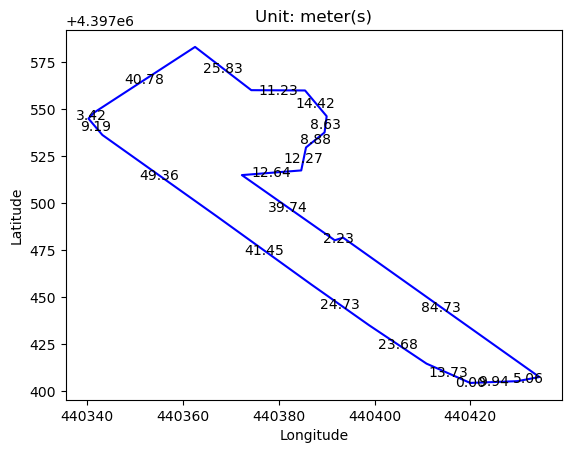

In [19]:
CPP_Planner_Kit.show_polygon_edge_length(single_polygon)

In [20]:
def convex_partition(polygon):
    # 将输入多边形转换为Shapely的Polygon对象
    # polygon = Polygon(polygon)

    # 初始化凸多边形列表
    convex_polygons = []

    # 创建初始分割线段
    segment = linemerge([polygon.exterior])

    # 迭代进行凸分割
    while segment:
        # 提取分割线段的坐标点
        coords = list(segment.coords)

        # 创建凸多边形
        convex_polygon = Polygon(coords)

        # 将凸多边形添加到列表中
        convex_polygons.append(convex_polygon)

        # 从原多边形中移除已分割的部分
        polygon = polygon.difference(convex_polygon)

        # 创建剩余部分的分割线段
        segment = linemerge([polygon.exterior])

    return convex_polygons
# convex_polygons = convex_partition(single_polygon)

# 测试分割多边形

In [21]:
print(type(single_polygon))
print(type(split_line))
split_polygons = CPP_Planner_Kit.split_polygon_through_1edge(single_polygon, split_line)
print(type(split_polygons))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.linestring.LineString'>
<class 'shapely.geometry.collection.GeometryCollection'>


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


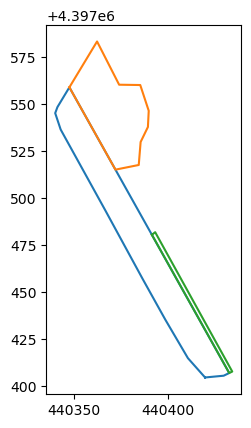

In [25]:
fig, ax = plt.subplots()
for geom in split_polygons.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y)
ax.set_aspect('equal')

In [ ]:
CPP_Planner_Kit.show_geometry_collection(split_polygons)